### Определение напряженного состояния и сети трещин - инициаторов событий

In [1]:
from methods.stress_classes import StressTensor

# Для определдения напряженного состояния в географической системе координат используется материнский класс тензора напряжений StressTensor.
# Задаются главные компоненты, изначально ориентированные по сторонам света и три угла эйлера
# В начальной системе координат ось x направлена на восток, y - на север, z - вверх 

# Далее над исходным тензором совершается три поворота, для которых задаётся три угла вращения:
# 1) trend - угол поворота вокруг оси z — задаёт направление проекции σ1 на горизонтальную плоскость.
# Отсчитывается по часовой стрелке от севера (оси Y) в градусах. При повороте ось x переходит в ось x',
# y переходит в y'

# 2) plunge - угол наклона σ₁ вниз от горизонтали (в градусах).
# Поворот происходит вокруг новой оси y' в положительном направлении.
# При этом ось z переходит в ось Z, x' переходит в x"

# 3) rake - угол поворота в положительном направлении вокруг новой оси Z, 
# задающий ориентацию векторов в плоскости x"-y', которые переходят в оси X и Y соотвественно
my_new_stress_tensor = StressTensor(principal_stresses=[10, 20, 60], trend=30, plunge=5, rake=3)

# и вот наш тензор
print(my_new_stress_tensor.tensor)

[[12.34749468  3.88170857  3.78030942]
 [ 3.88170857 18.03210343 -2.12996458]
 [ 3.78030942 -2.12996458 59.62040189]]


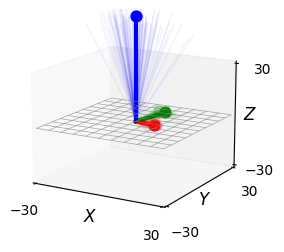

In [8]:
from methods.stress_classes import RandomStressTensor
from methods.stress_plotting import plot_stress_tensor_with_rotated_ensemble 

# Создание ансамбля случайных тензоров для того, чтобы анализировать их всех сразу
# Просто ансамбль из N тензоров с нормальными распределениями всех или некоторых величин
tensor = RandomStressTensor([10, 20, 60], trend=10, plunge=0, rake=0)
ensemble_tensors, stresses, trends, plunges, rakes = tensor.generate_ensemble(
    N=200,
    stress_std_frac=0.05,
    angle_std_deg=10,
)
# функция возвращает вектора соответствующих параметров

# отрисовка ансамбля тензоров
plot_stress_tensor_with_rotated_ensemble(
    tensor,
    ensemble_stresses=stresses,
    ensemble_trends=trends,
    ensemble_plunges=plunges,
    ensemble_rakes=rakes,
    max_ensemble_to_plot=100
)

# после генерации параметры ансамбля доступны в виде атрибутов обьекта tensor:
stresses = tensor.ensemble_principal_stresses # например значения главных компонент

[[24.80641936  6.00683235  0.        ]
 [ 6.00683235 39.12374741  0.        ]
 [ 0.          0.         60.        ]]


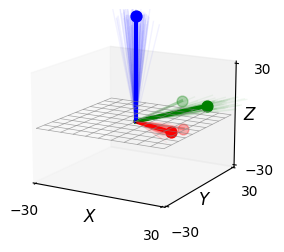

In [2]:
from methods.stress_classes import FrictionalStressTensor
from methods.stress_plotting import plot_stress_tensor_with_rotated_ensemble 

# Ансамбль тензоров, полученных из предположения о фрикционном равновесии напряженного состояния массива. 
# Тензор напряжений в условии фрикционного равновесия задаётся исходя из того, что эффективная окружность 
# Мора для пары главных напряжений σ₁',σ3' лишь касается прямой критерия Кулона τ=μ σn'+C. 
# При заданном максимальном эффективном напряжении σ1'=σ1-p и известных коэффициенте внутреннего трения μ и когезии C 
# минимальное эффективное напряжение σ_3' определяется из геометрического условия касания:
# σ3'=((√(1+μ^2 )-μ) σ1'-2C)/(√(1+μ^2 )+μ),
# после чего к обоим напряжениям возвращается поровое давление p, получая σ3=σ3'+p.
# Промежуточное главное напряжение берётся как σ2=σ3+ρ (σ1-σ3 ),  0≤ρ≤1, 
# где параметр ρ задаёт относительное положение σ2 между σ1 и σ3. 
# Вектор главных напряжений [σ1, σ2, σ3] размещается вдоль осей x,y,z согласно порядку кодов строки mode, 
# а затем поворачивается в глобальную систему «восток – север – вверх» триадой углов Эйлера 

tensor = FrictionalStressTensor(s1=60, mode='zyx', ratio=0.5, pore_pressure=5, mu=0.6, cohesion=0.01, trend=20, plunge=0, rake=0)

# при создании ансамбля тензоров случайным образом варьируется σ1, остальное получается по алгоритму, описанному выше
ensemble_tensors, stresses, trends, plunges, rakes = tensor.generate_ensemble(
    N=200,
    stress_std_frac=0.05,
    angle_std_deg=5,
    random_s2 = True, # будем делать промежуточное главное напряжение случайным между максимальным и минимальным
)

print(tensor) # материнский тензор

# отрисовка ансамбля тензоров
plot_stress_tensor_with_rotated_ensemble(
    tensor,
    ensemble_stresses=stresses,
    ensemble_trends=trends,
    ensemble_plunges=plunges,
    ensemble_rakes=rakes,
    max_ensemble_to_plot=100
)

# после генерации параметры ансамбля доступны в виде атрибутов обьекта tensor:
stresses = tensor.ensemble_principal_stresses # например значения главных компонент

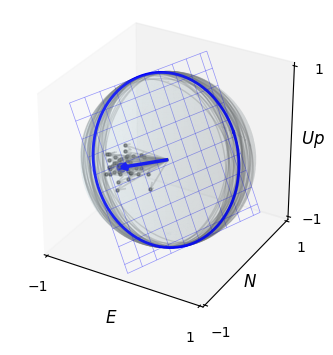

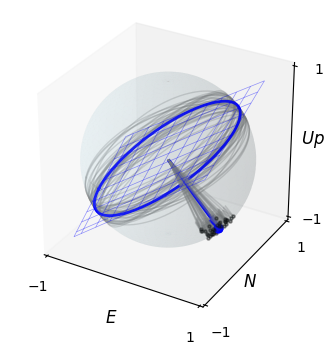

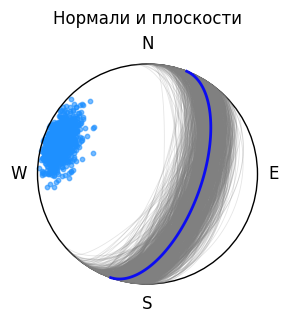

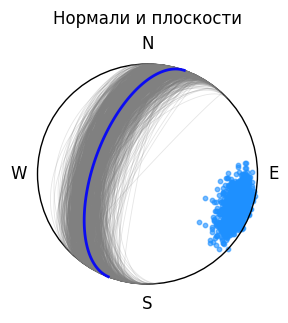

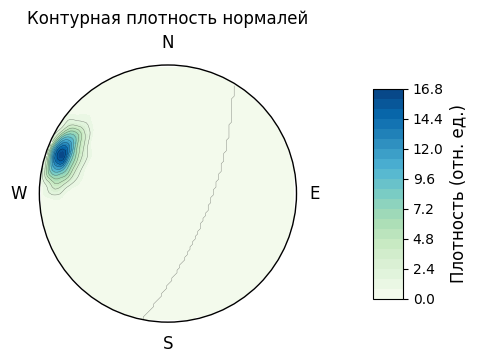

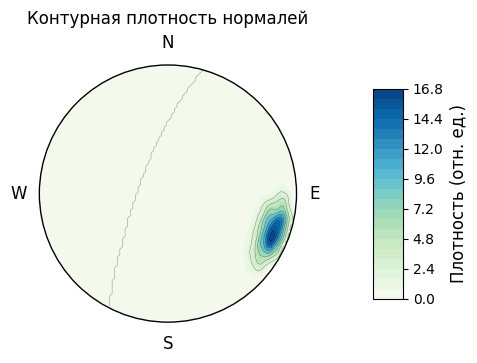

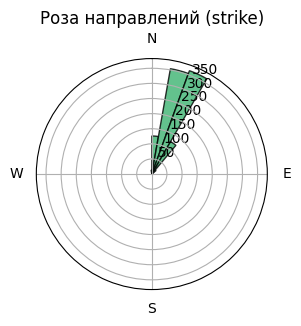

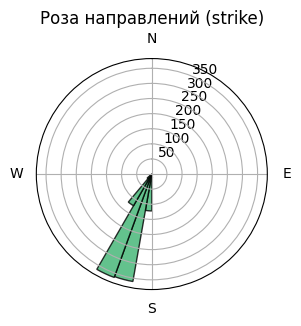

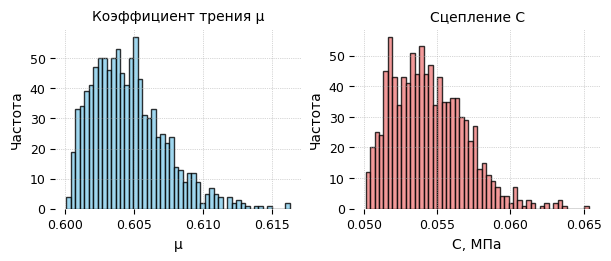

In [3]:
import numpy as np
from methods.frac_classes import RandomFractureSeed, FisherFractureSeed
from methods.frac_plotting import plot_fracture_ensemble_on_sphere, plot_fracture_normals_and_planes, plot_fracture_density, plot_fracture_strike_rose, plot_mu_cohesion_histograms
from methods.colomb_things import get_critical_strike_dip

# вычисляем для объекта tensor какие должны быть угла у плоскости трещины, чтобы она бала наиболее близка к скольжению 
# то есть у нее максимальное значение отношения касательного к нормальному напряжения
((crit_strike, crit_dip), (crit_strike_c, crit_dip_c)) = get_critical_strike_dip(tensor, tensor.mu) # два набора сопряженных углов

# Создание ансамблей трещин, ориентированных согласно распределению Фишера
# коэффициенты трения и когезии могут быть одинаковы для всех трещин, 
# либо можно сделать распределенными согласно распределению Вейбулла, 
# тогда нужно передать параметры распределения, см описание класса

# создаём объект матринской трещины:
seed = FisherFractureSeed(strike=crit_strike, dip=crit_dip, mu=0.6, cohesion=0.05)
cseed = FisherFractureSeed(strike=crit_strike_c, dip=crit_dip_c, mu=0.6, cohesion=0.05) # для сопряженных углов

# параметры материнской трещины доступны в атрибутах объекта, например
seed.mu, seed.normal # и т.д.

# генерируем для него ансамбль из нужного количства случайно ориентированных трещин. 
# Если не задавать параметры масштаба, типа mu_weibull_scale, то все коэффициенты mu будут как у матринской трещины
# получаем массив из N векторов нормалей к плоскости трещин, и всего прочего, что может понадобится
normals, strikes, dips, mus, cohesions = seed.generate_ensemble(N=1000, kappa=50, mu_weibull_scale=0.005, cohesion_weibull_scale=0.005)
cnormals, cstrikes, _, _, _ = cseed.generate_ensemble(N=1000, kappa=50, mu_weibull_scale=0.005, cohesion_weibull_scale=0.005) # для сопряженных углов

# для ориентаций трещин можно воспользоваться другим классом, с нормально распределенными углами страйк и дип,
# возможно это в будущем пригодится для модели восстановления ориентации
# seed = RandomFractureSeed(strike=10, dip=90)
# normals, strikes, dips, mus, cohesions = seed.generate_ensemble(N=500, strike_std=20, dip_std=20)

normals_and_cnormals = np.vstack((normals, cnormals)) # стакаем вместе сопряженные наборы
strikes_and_csrikes = np.vstack((strikes, cstrikes))

# визуализация разными способами
plot_fracture_ensemble_on_sphere(normals, seed)
plot_fracture_ensemble_on_sphere(cnormals, cseed)
plot_fracture_normals_and_planes(normals, seed)
plot_fracture_normals_and_planes(cnormals, cseed)
plot_fracture_density(normals)
plot_fracture_density(cnormals)
plot_fracture_strike_rose(strikes)
plot_fracture_strike_rose(cstrikes)

# Распрелделения параметров трения и когезии для ансамбля:
plot_mu_cohesion_histograms(mus, cohesions)

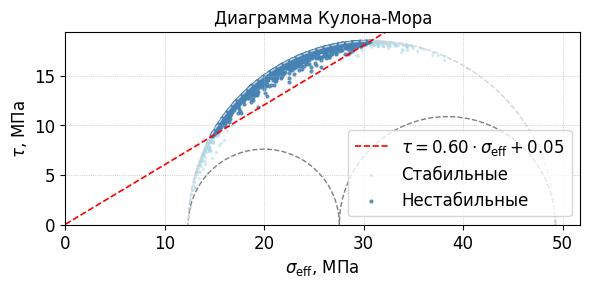

In [4]:
from methods.colomb_things import critical_pore_pressure, compute_normal_and_shear_ensemble, check_coulomb_failure
from methods.colomb_things_plotting import plot_coulomb_diagram, plot_coulomb_diagram_density


cpp_31, cpp_21, cpp_32 = critical_pore_pressure(tensor.principal_stresses, seed.mu, seed.cohesion) 
# Эта функция считает, какое должно быть поровое давление для материнского тензора и сида, 
# чтобы каждый из кругов Мора коснулся критерия Кулона. То есть это нужный сдвиг круга вдоль оси сигма н до точки касания с прямой
# Ответ в тех же единицах, что и стресс - в МПа
# если tensor - объект класса FrictionalStressTensor, то cpp_31, очевидно, будет такое же, как было задано при его инициализации

# Теперь можно считать, какие трещины критически напряжены, для этого есть две функции:

# Нормальные и касательные напряжения. Считается сразу для всего бэтча из тензоров.
# Каждый тензор из ансамбля пересчитывается в нормальные и касательные напряжения для каждой нормали.
# нормали берем вместе с сопряженными, отчего же не взять
ensemble_sigma_n, ensemble_tau = compute_normal_and_shear_ensemble(ensemble_tensors, normals_and_cnormals)

# Чекаем, для каких трещин выполнился критерий Кулона, также сразу для всех тензоров. 
# В качестве порового давления подставляем каке то, в даннлм случае критическое + 5 МПа.
# mu и cohesion можно передать единичные значения либо вектора, полученные из seed.generate_ensemble 
ensemble_failures = check_coulomb_failure(ensemble_sigma_n, ensemble_tau, mu=seed.mu, cohesion=seed.cohesion, pore_pressure=cpp_31+5)

# можно визуализировать всю красоту в виде диграммы Кулона
idx=42 # номер какого то тензора из батча тензоров напряжений

# для него:
sigma_n = ensemble_sigma_n[idx] # нормальные напряжения для всех трещин из ансамбля
tau = ensemble_tau[idx] # касательные напряжения для всех трещин из ансамбля
mu = seed.mu # коэффициенты трения и когезии для отрисовки прямой критерия
cohesion = seed.cohesion 
principal_stresses = stresses[idx] # главные компоненты тензора напряжений для отрисовки кругов Мора
failures = ensemble_failures[idx] # метки выполненности критерия Кулона для трещин из ансамбля, чтобы точки по разному раскрасить, если не передавать тогда сами посчитаются

plot_coulomb_diagram(sigma_n, tau, mu, cohesion, pore_pressure=cpp_31+5, principal_stresses=principal_stresses, failures=failures)

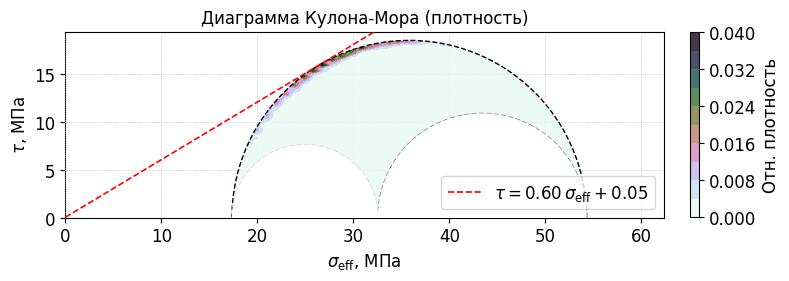

In [5]:
# то же самое, в виде плотности
plot_coulomb_diagram_density(sigma_n, tau, mu, cohesion, pore_pressure=cpp_31, principal_stresses=principal_stresses)

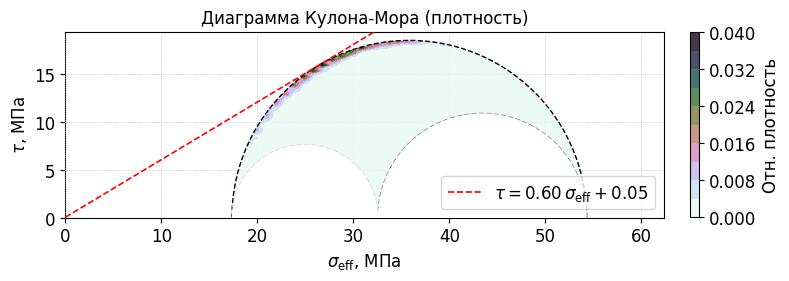

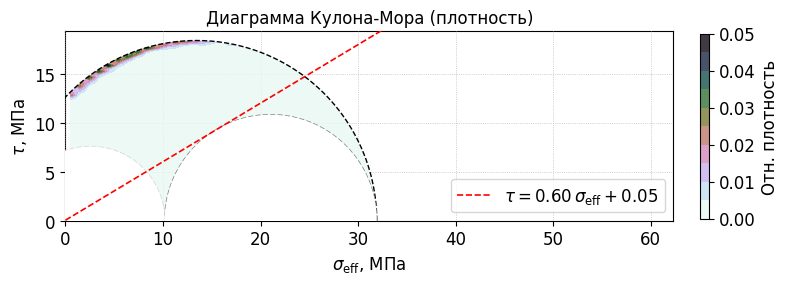

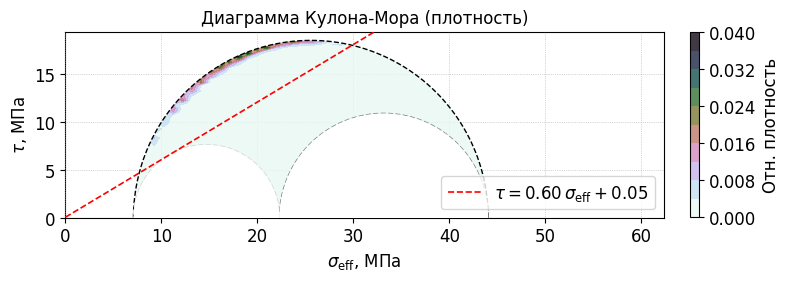

In [6]:
# Моменты касания кругов для конкретного тензора:
idx=42 # номер какого то тензора из батча тензоров напряжений

# для него:
sigma_n = ensemble_sigma_n[idx] # нормальные напряжения для всех трещин из ансамбля
tau = ensemble_tau[idx] # касательные напряжения для всех трещин из ансамбля
mu = seed.mu # коэффициенты трения и когезии для отрисовки прямой критерия
cohesion = seed.cohesion 
principal_stresses = stresses[idx] # главные компоненты тензора напряжений для отрисовки кругов Мора

# Поровые давления для конкретного тензора с idx=42, соответсвующие касаниям кругов:
cpp_31, cpp_21, cpp_32 = critical_pore_pressure(principal_stresses, mu, cohesion) 

plot_coulomb_diagram_density(sigma_n, tau, mu, cohesion, pore_pressure=cpp_31, principal_stresses=principal_stresses)
plot_coulomb_diagram_density(sigma_n, tau, mu, cohesion, pore_pressure=cpp_21, principal_stresses=principal_stresses)
plot_coulomb_diagram_density(sigma_n, tau, mu, cohesion, pore_pressure=cpp_32, principal_stresses=principal_stresses)

### Моделирование микросейсмичности в процессе закачки жидкости

In [1]:
# Импорты всего
import numpy as np
from types import SimpleNamespace
from methods.frac_classes import FisherFractureSeed
from methods.frac_plotting import plot_fracture_ensemble_on_sphere, plot_fracture_normals_and_planes, plot_fracture_density, plot_fracture_strike_rose, plot_mu_cohesion_histograms
from methods.stress_classes import FrictionalStressTensor
from methods.stress_plotting import plot_stress_tensor_with_rotated_ensemble 
from methods.colomb_things import compute_normal_and_shear_ensemble, get_critical_strike_dip, critical_pore_pressure
from methods.events import simulate_microseismicity_over_time, compute_normalized_event_curve
from methods.events_plotting import plot_events_and_pressure_vs_time, plot_events_vs_pressure
from methods.colomb_things_plotting import plot_coulomb_diagram, plot_coulomb_diagram_density

In [2]:
# На основе всго, что было выше, можно смоделировать микросейсмичность, возникающую в ходе роста порового давления.

# Шаг 0, задаём нужные параметры моделирования
ro_s = 2300 # плотность породы, kg/m3
ro_f = 1000 # плотность флюида
poisson = 0.3 
depth = 2000 # m 
sv = ro_s * 9.81 * depth * 1e-6  # вертикальное напряжение, MPa 
pore_press = ro_f * 9.81 * depth * 1e-6  # поровое давление, MPa

# Кривая изменения порового давления (линейная)
# от начального давления до + 10 МПа
steps = 1000 
delta_P = 15 # MPa
pore_pressure_vs_time = np.linspace(pore_press, pore_press + delta_P, steps)
time = np.linspace(0, steps*3600, steps) # время, steps часов

# Можно сделать объект с параметрами моделирования, просто для удобства, чтобы были все в одном месте, и не надо было собирать по всему коду, 
# если понадобится что то из этого варьировать
params = SimpleNamespace(
    # для тензоров
    s1 = sv,
    pore_pressure = pore_press,

    # для трещин
    mu = 0.6,
    cohesion = 0.05,
    kappa = 5,
    N = 10000
)

# Шаг 1: Создаём объект материнского тензора напряжений
tensor = FrictionalStressTensor(s1=params.s1, mode='zyx', ratio=0.5, 
                                pore_pressure=params.pore_pressure, 
                                mu=params.mu, cohesion=params.cohesion, 
                                trend=0, plunge=0, rake=0)

# семплируем бэтч случайных тензоров
tensors_batch, principal_stresses, _, _, _ = tensor.generate_ensemble(
    N=50,
    stress_std_frac=0.05, # 5% стд для s1
    angle_std_deg=(5, 0, 0), # 5 градусов вариаций по ориентации в горизонтальной плоскости, остальные одинаковые
    random_s2 = True, # будем делать промежуточное главное напряжение случайным между максимальным и минимальным
)

# Шаг 3: Создаём объект материнской трещины и сэмплируем ансамбль терщин
# находим углы наибольшего сдвига (обычный и сопряженной)
((strike, dip), (cstrike, cdip)) = get_critical_strike_dip(tensor, tensor.mu) 

# объектs материнской трещины (обычный и сопряженной)
seed = FisherFractureSeed(strike, dip, mu=params.mu, cohesion=params.cohesion)
cseed = FisherFractureSeed(cstrike, cdip, mu=params.mu, cohesion=params.cohesion)

# ансамбли нормалей
normals, _, _, _, _ = seed.generate_ensemble(N=params.N//2, kappa=params.kappa)
cnormals, _, _, _, _ = cseed.generate_ensemble(N=params.N//2, kappa=params.kappa)
normals_and_cnormals = np.vstack((normals, cnormals)) # стакаем вместе сопряженные наборы нормалей

# Шаг 4: Расчёт нормальных и касательных напряжений
sigma_n, tau = compute_normal_and_shear_ensemble(tensors_batch, normals_and_cnormals) # (N, M)

# Шаг 5: Расчёт событий. В качестве параметров mu и cohesion можно передать как единичные значения, так и вектора значений, если они разные для разных трещин
events_vs_time = simulate_microseismicity_over_time(sigma_n, tau, params.mu, params.cohesion, pore_pressure_vs_time)
# получаем количество событий на каждом шаге изменения давления для бетча тензоров

# Шаг 6: Можно теперь перенормировать события в распредлеления по времени, чтобы уйти от конкретного числа событий
# распределдние количества событий можно строить по минутам, часам или дням, 
# для этого надо указаь time_unit='m' (или 'h' или 'd', подразумевая, что вектор времени указан в секундах) 
# функция возвращает вектор времен - центры соотвествующих бинов
# binned_events - нормированное количество событий, в сумме будет 1 для каждото тензора из бэтчя 
times, binned_events = compute_normalized_event_curve(time, events_vs_time, time_unit='h')

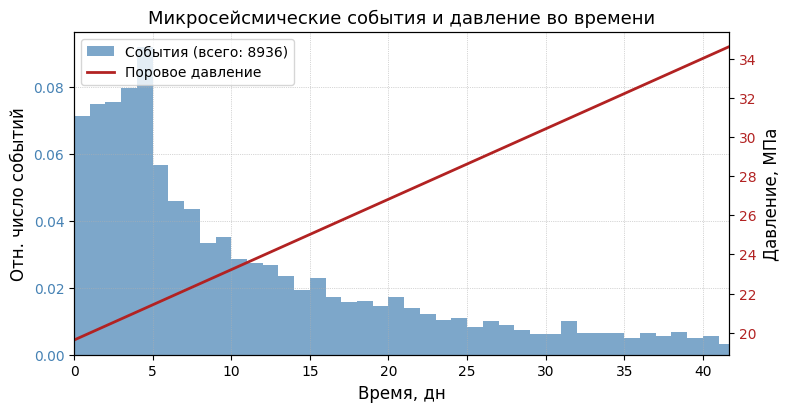

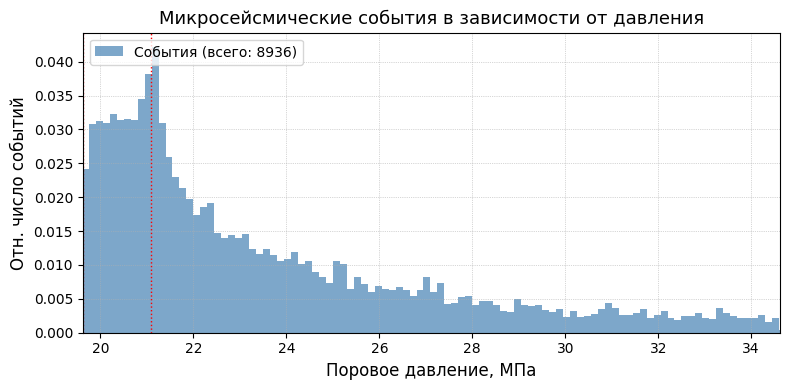

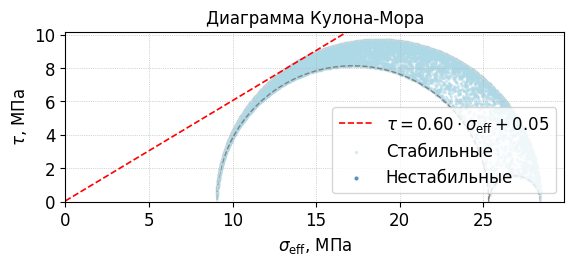

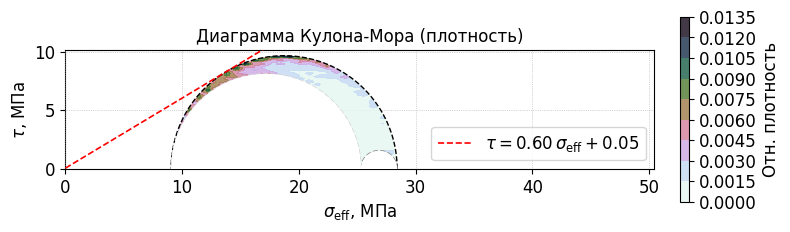

In [12]:
# Шаг 7: Рисуем графики, любуемся
idx = 42 # какой то тензор

# давления касания кругов, чирбы отложить их на графике
cpp_31, cpp_21, cpp_32 = critical_pore_pressure(principal_stresses[idx], params.mu, params.cohesion) 
cpps = (cpp_31, cpp_21, cpp_32) 

plot_events_and_pressure_vs_time(time, events_vs_time[idx], pore_pressure_vs_time, time_unit='d') 
plot_events_vs_pressure(pore_pressure_vs_time, events_vs_time[idx], cpps=cpps)

# Если что, пики на некоторых графиках соответствуют касанию нижнего круга, нужно как то это проинтерпретировать
time_idx = 00 
plot_coulomb_diagram(sigma_n[idx], tau[idx], 
                     params.mu, params.cohesion, 
                     pore_pressure=pore_pressure_vs_time[time_idx], 
                     principal_stresses=principal_stresses[idx])

plot_coulomb_diagram_density(sigma_n[idx], tau[idx], 
                     params.mu, params.cohesion, 
                     pore_pressure=pore_pressure_vs_time[time_idx], 
                     principal_stresses=principal_stresses[idx])

In [26]:
cpps

(np.float64(19.62),
 np.float64(43.39976552938378),
 np.float64(21.765524022055587))